### Random Forest

It is produced randomized multiple decision trees that work as an ensemble. This classifier “can handle high data dimensionality and multicollinearity. Another advantage is that it can be dealing with unbalanced data, as in this case.

#### Import Data and Libraries

In this section I create 3 datasets: 
1. Complete Dataset with all data
2. Data of individuals who have a high Climate Change Risk Perception (q2 >= 6) 
2. Data of individuals who have Low Climate Change Risk Perception (q2 <= 5) 

With all datasets I will predict pro-environmental behaviour (qb5). 

In [2]:
# Import Data 
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss


df = pd.read_csv('df-climatechange.csv')
df = df.drop([ 'qb1a'], axis = 1)
#df['pro-environmental behaviour'] = df['pro-environmental behaviour'].replace({'No': 0, 'Yes':1})

#two subset
df1 = df[df['risk perception'] >= 6]
df2 = df[df['risk perception'] <= 5]

In [3]:
len(df)

21978

#### Set parameters Random Search

In [4]:

#parameter for random search 

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 400, num = 6)]
max_depth = [5, 8, 15, 25, 30, None]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 
max_features = ["auto", "sqrt", "log2"]
bootstrap =   [True, False]

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, 
                 max_features = max_features,
                 bootstrap = bootstrap)
param_grid

{'n_estimators': [50, 120, 190, 260, 330, 400],
 'max_depth': [5, 8, 15, 25, 30, None],
 'min_samples_split': [2, 5, 10, 15, 100],
 'min_samples_leaf': [1, 2, 5, 10],
 'max_features': ['auto', 'sqrt', 'log2'],
 'bootstrap': [True, False]}

### Complete Dataset

In this part there is the complete dataset. I will predict pro-environmental behaviour (qb5). The predictors are: climate change risk perception, clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 

In [5]:

cc_num = df[['pro-environmental behaviour', 'risk perception' , 'political orientation', 'gender','age', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']]

cat_var =['political orientation','gender', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)

seed = 101
#### Split the data into X and y and create training and validating set
X = df_get_dummies.drop('pro-environmental behaviour',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'pro-environmental behaviour']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

In [6]:
X.shape

(21978, 65)

In [7]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.43641457, 0.76697577])

#### Random search
Random search is a tuning technique that attempts to compute the best values of hyperparameters.

In [8]:
rf = RandomForestClassifier( class_weight={0: 1.43631197 , 1:0.76700502})
# Random search of parameters, using 3 fold cross validation, 
rf_classifier = RandomizedSearchCV(rf, param_grid, cv = 3, 
                  
                                   n_jobs = -1, random_state = seed)


rf_classifier.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 1.43631197,
                                                                  1: 0.76700502}),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 15, 25, 30, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [50, 120, 190, 260, 330,
                                                         400]},
                   random_state=101)

In [9]:
print(rf_classifier.best_params_)
print(rf_classifier.best_estimator_)

{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 25, 'bootstrap': True}
RandomForestClassifier(class_weight={0: 1.43631197, 1: 0.76700502},
                       max_depth=25, max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=400)


#### Confusion Matrix

Text(0.5, 19.5, 'Predicted label')

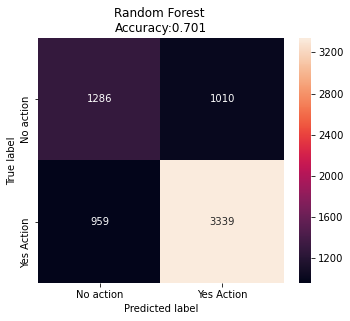

In [10]:
y_pred = rf_classifier.best_estimator_.predict(X_test)

ac = accuracy_score(y_test,rf_classifier.best_estimator_.predict(X_test))
#print('Accuracy is: ',ac)

plt.figure(figsize=(5.5,4.5))

cm_df = confusion_matrix(y_test,rf_classifier.best_estimator_.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, rf_classifier.best_estimator_.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix.png')


#### Feature importance

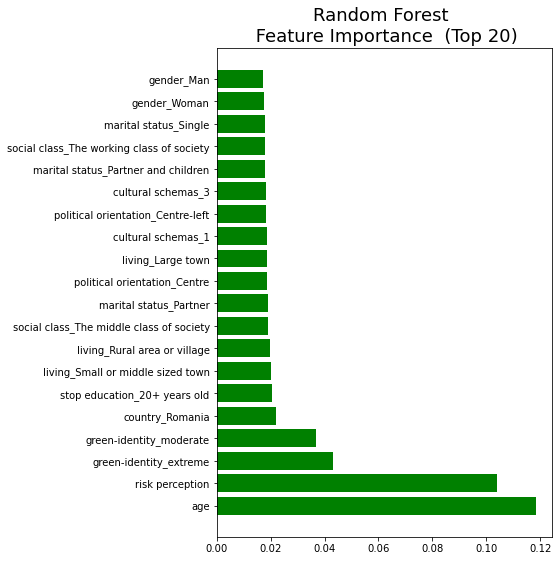

In [11]:
feature_importances = list(zip(X_train, rf_classifier.best_estimator_.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 9))

plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Random Forest \n Feature Importance  (Top 20)',
          fontdict= {'fontsize' : 18})
plt.show()

In [12]:
imp = pd.read_csv('imp.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)

dt = pd.DataFrame(feature_importances)
dt.rename(columns={ dt.columns[0]: "variable" }, inplace = True)

dt  = dt.sort_values('variable', ascending=True).reset_index(drop=True)

final = pd.merge(imp, dt, left_index=True, right_index=True)

final.rename(columns={ final.columns[4]: "importance_rf" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)


final.to_csv('imp.csv', index=False, encoding='utf-8')


In [13]:
print(classification_report(y_test, rf_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57      2296
           1       0.77      0.78      0.77      4298

    accuracy                           0.70      6594
   macro avg       0.67      0.67      0.67      6594
weighted avg       0.70      0.70      0.70      6594



#### ROC 

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.

roc_auc_score for Random Forest - High Risk Perception:  0.7328906119530517


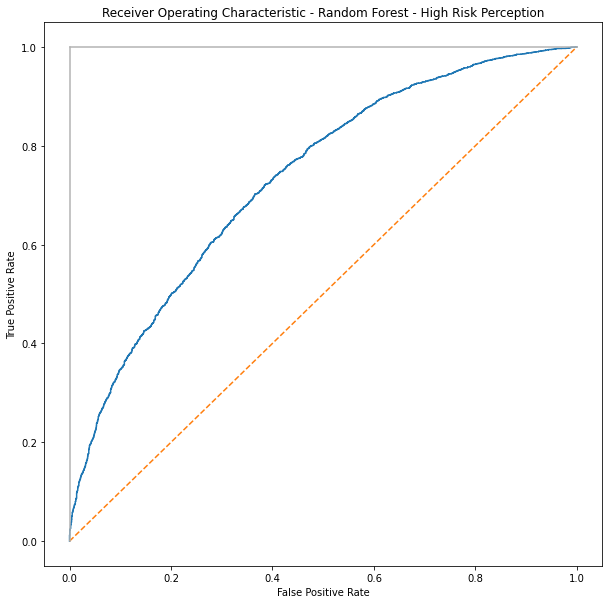

In [164]:
y_score2 = rf_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest - High Risk Perception')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### High Risk Perception

In this part there is data of individuals who have a high Climate Change Risk Perception (q2 >= 6).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes

In [32]:

cc_num = df1[['pro-environmental behaviour' , 'political orientation', 'gender','age', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']]

cat_var =['political orientation','gender', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('pro-environmental behaviour',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'pro-environmental behaviour']

seed = 456  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

In [33]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.56726931, 0.73424266])

In [34]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight= {0: 1.56739773 , 1:0.73421448})
# Random search of parameters, using 3 fold cross validation, 
rf_classifier = RandomizedSearchCV(rf, param_grid, cv = 3, 
                  
                                   n_jobs = -1,random_state = seed, scoring='f1')


# Fit the random search model
rf_classifier.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 1.56739773,
                                                                  1: 0.73421448}),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 15, 25, 30, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [50, 120, 190, 260, 330,
                                                         400]},
                   random_state=456, scoring='f1')

In [35]:
print(rf_classifier.best_params_)
print(rf_classifier.best_estimator_)


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}
RandomForestClassifier(class_weight={0: 1.56739773, 1: 0.73421448},
                       max_depth=30, n_estimators=400)


Text(0.5, 19.5, 'Predicted label')

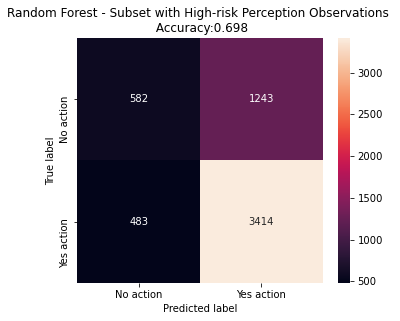

In [36]:
y_pred = rf_classifier.best_estimator_.predict(X_test)

ac = accuracy_score(y_test,rf_classifier.best_estimator_.predict(X_test))

plt.figure(figsize=(5.5,4.5))
cm_df = confusion_matrix(y_test,rf_classifier.best_estimator_.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes action'], 
                     columns = ['No action','Yes action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest - Subset with High-risk Perception Observations \n Accuracy:{0:.3f}'.format(accuracy_score(y_test, rf_classifier.best_estimator_.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


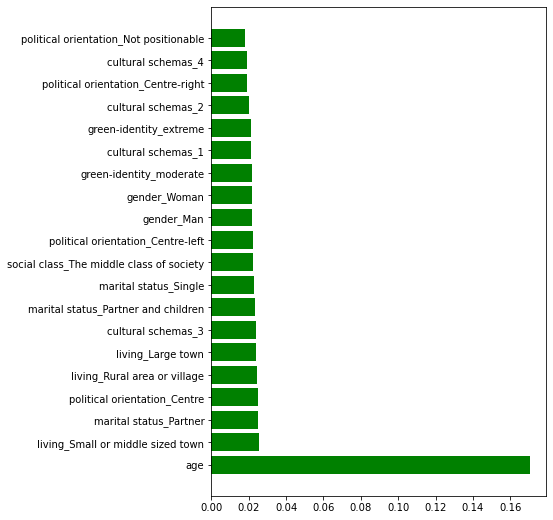

In [37]:

feature_importances = list(zip(X_train, rf_classifier.best_estimator_.feature_importances_))
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 9))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
#plt.title('Random Forest - Feature Importance (Top 20) \n Subset with High-risk Perception Observations',
#          fontdict= {'fontsize' : 18})
plt.show()


In [38]:
imp = pd.read_csv('imp2.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)
dt = pd.DataFrame(feature_importances)
dt.rename(columns={ dt.columns[0]: "variable" }, inplace = True)
dt  = dt.sort_values('variable', ascending=True).reset_index(drop=True)
final = pd.merge(imp, dt, left_index=True, right_index=True)

final.rename(columns={ final.columns[4]: "importance_rf" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)

final.to_csv('imp2.csv', index=False, encoding='utf-8')

In [39]:
print(classification_report(y_test, rf_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.55      0.32      0.40      1825
           1       0.73      0.88      0.80      3897

    accuracy                           0.70      5722
   macro avg       0.64      0.60      0.60      5722
weighted avg       0.67      0.70      0.67      5722



roc_auc_score for Random Forest - High Risk Perception:  0.6926570140009349


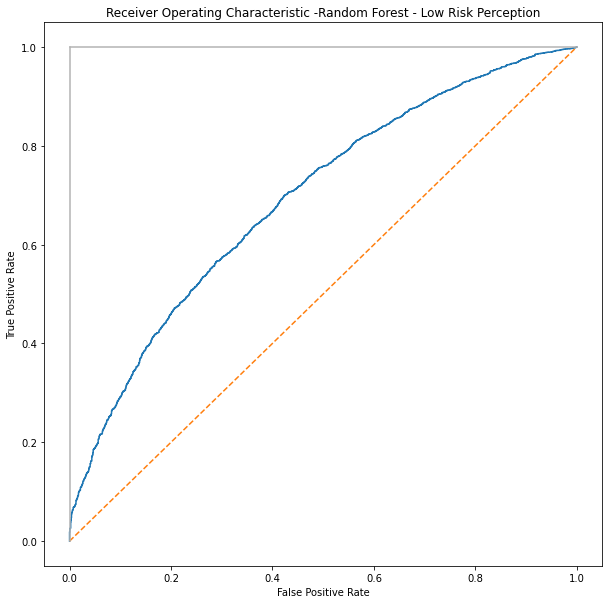

In [84]:
y_score2 = rf_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic -Random Forest - Low Risk Perception')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Low Risk Perception


In this part there is data of individuals who have a low Climate Change Risk Perception (q2 <= 5).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes


In [24]:

cc_num = df2[['pro-environmental behaviour' , 'political orientation', 'gender','age', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']]

cat_var =['political orientation','gender', 'country','stop education','living', 'social class','marital status','green-identity', 'cultural schemas']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)


X = df_get_dummies.drop('pro-environmental behaviour',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'pro-environmental behaviour']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)


In [25]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))


print(class_weights)

[0.92707384 1.08537887]


In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight= {0:0.9272727 , 1:1.08510638})

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_classifier = RandomizedSearchCV(rf, param_grid, cv = 3, 
                  
                                   n_jobs = -1,random_state = seed, scoring = 'f1')


# Fit the random search model
rf_classifier.fit(X_train, y_train.values.ravel())


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 0.9272727,
                                                                  1: 1.08510638}),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 15, 25, 30, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [50, 120, 190, 260, 330,
                                                         400]},
                   random_state=456, scoring='f1')

In [27]:
print(rf_classifier.best_params_)
print(rf_classifier.best_estimator_)

{'n_estimators': 120, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 25, 'bootstrap': False}
RandomForestClassifier(bootstrap=False,
                       class_weight={0: 0.9272727, 1: 1.08510638}, max_depth=25,
                       max_features='log2', min_samples_leaf=5,
                       min_samples_split=100, n_estimators=120)


Text(0.5, 19.5, 'Predicted label')

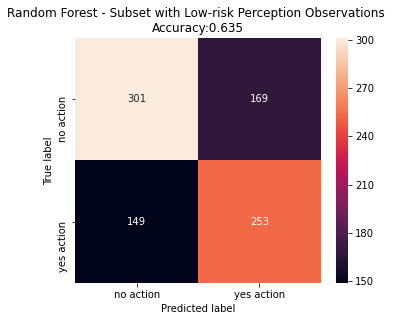

In [28]:
ac = accuracy_score(y_test,rf_classifier.best_estimator_.predict(X_test))

plt.figure(figsize=(5.5,4.5))

cm_df = confusion_matrix(y_test,rf_classifier.best_estimator_.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['no action','yes action '], 
                     columns =  ['no action','yes action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest - Subset with Low-risk Perception Observations \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, rf_classifier.best_estimator_.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


In [29]:
print(classification_report(y_test, rf_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       470
           1       0.60      0.63      0.61       402

    accuracy                           0.64       872
   macro avg       0.63      0.63      0.63       872
weighted avg       0.64      0.64      0.64       872



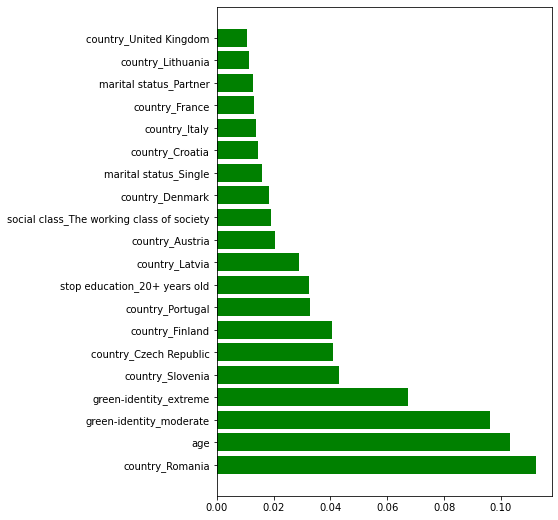

In [30]:
feature_importances = list(zip(X_train, rf_classifier.best_estimator_.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 9))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
#plt.title('Random Forest - Feature Importance (Top 20) \n Subset with Low-risk Perception Observations',
#          fontdict= {'fontsize' : 18})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [31]:
imp = pd.read_csv('imp3.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)

dt = pd.DataFrame(feature_importances)
dt.rename(columns={ dt.columns[0]: "variable" }, inplace = True)

dt  = dt.sort_values('variable', ascending=True).reset_index(drop=True)

final = pd.merge(imp, dt, left_index=True, right_index=True)

final.rename(columns={ final.columns[4]: "importance_rf" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)


final.to_csv('imp3.csv', index=False, encoding='utf-8')

roc_auc_score for Random Forest - Low Risk Perception:  0.6792023922938499


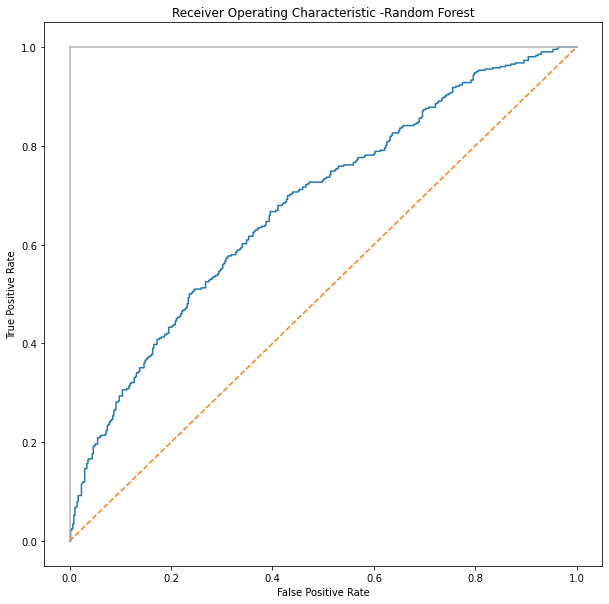

In [114]:
y_score2 = rf_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - Low Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic -Random Forest')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### REFERENCES 

https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

